In [57]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role

# 1. Data

Datasets: https://www.kaggle.com/c/titanic/data

In [65]:
bucket = ''
prefix_input = 'datasets/titanic-binary'
objectName = 'train.csv'

prefix_prepared = 'datasets/titanic-prepared'
prefix_output = 'datasets/titanic-model'

In [ ]:
dfPath = 's3://{}/{}/{}'.format(bucket, prefix_input, objectName)
dfPath

In [159]:
df = pd.read_csv(dfPath)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Rearrange for Sagemaker

In [160]:
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [161]:
df = df[['Survived', 'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
df.drop(['Name', 'Ticket'], inplace=True, axis=1)
df.head()

,Survived,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,1,3,male,22.0,1,0,7.2500,NaN,S
1,1,2,1,female,38.0,1,0,71.2833,C85,C
2,1,3,3,female,26.0,0,0,7.9250,NaN,S
3,1,4,1,female,35.0,1,0,53.1000,C123,S
4,0,5,3,male,35.0,0,0,8.0500,NaN,S


In [158]:
df.Cabin.nunique()

147

## One hot encoding

In [162]:
dfEncoded = pd.get_dummies(df)
dfEncoded.head()

,Survived,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A10,...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,1,3,22.0,1,0,7.2500,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,2,1,38.0,1,0,71.2833,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,3,3,26.0,0,0,7.9250,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,4,1,35.0,1,0,53.1000,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,5,3,35.0,0,0,8.0500,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [163]:
dfEncoded.isna().values.any()

True

In [164]:
dfEncoded = dfEncoded.fillna(0)

In [165]:
dfEncoded.isna().values.any()

False

In [167]:
print('{} columnas'.format(len(dfEncoded.columns)))

159 columnas


## Split train / test

In [328]:
msk = np.random.rand(len(dfEncoded)) < 0.8
train = dfEncoded[msk]
test = dfEncoded[~msk]

In [169]:
print('{} registros para train'.format(len(train)))

713 registros para train


In [170]:
print('{} registros para test'.format(len(test)))

178 registros para test


## Upload data 

In [171]:
train.to_csv('s3://{}/{}/train/train.csv'.format(bucket, prefix_prepared), index=False, header = False)
test.to_csv('s3://{}/{}/test/test.csv'.format(bucket, prefix_prepared), index=False, header = False)

In [ ]:
's3://{}/{}/train/train.csv'.format(bucket, prefix_prepared)

# Train

In [173]:
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")
role = get_execution_role()
sagemaker_session = sagemaker.Session()
s3_output_path = 's3://{}/{}/'.format(bucket, prefix_output)

In [ ]:
s3_output_path

In [ ]:
role

In [176]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="DEMO-binary",
    output_path=s3_output_path,
)

In [183]:
estimator.set_hyperparameters(predictor_type='binary_classifier', feature_dim=len(dfEncoded.columns)-1, mini_batch_size=20)

In [ ]:
train_data = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix_prepared}/train/',
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None
)

test_data = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix_prepared}/test/",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None
)


estimator.fit({"train": train_data, "test": test_data})

# Deploy

In [185]:
linear_predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

---------------!

# Predict

In [301]:
# configure the predictor to accept to serialize csv input and parse the reposne as json
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

In [372]:
#we separate the label column and
testFeatures = test.iloc[:,1:]
testLabels = test.iloc[:,:1]

#Sagemaker needs a csv payload
payload = testFeatures.to_csv(index=False, header=False)

In [400]:
#Iterate over results
predictions = []
for row in payload.split('\n'):
    if(row != ''):
        response = linear_predictor.predict(row, initial_args={'ContentType': 'text/csv'})
        predictions.append(response['predictions'][0]['predicted_label'])

In [401]:
#Check if we have the same result count as the records tested
len(testFeatures) == len(predictions)

True

# Analyze results

In [431]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(testLabels.Survived, predictions)
print(cf_matrix)

[[117   6]
 [ 18  47]]


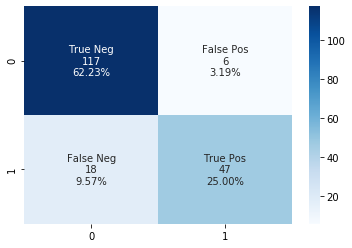

In [432]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')